_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_112 (Dropout)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 128)       640       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_113 (Dropout)        (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 128)       65664     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 7, 7, 128)         0         
__________

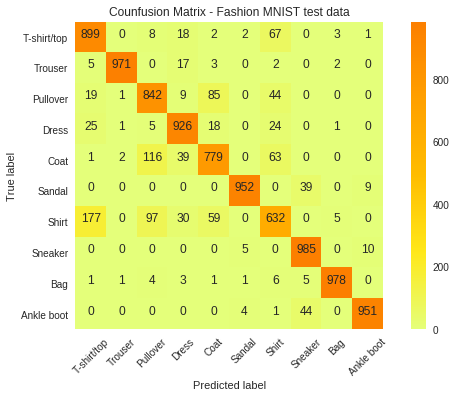

In [36]:
#coding:utf-8
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  
    y_label = 'True label'
    x_label = 'Predicted label'
    title = 'Counfusion Matrix - Fashion MNIST test data'
    save_path = 'confusin_matrix.png'
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j,i, str(cm[i][j]), horizontalalignment="center")
    plt.tight_layout()
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    ax = plt.gca() # get current axis
    ax.grid(False) 
    plt.savefig(save_path)


"""
データセットを取得
x_train: 学習画像データ(60000枚)
y_train: 学習画像データのラベル
x_test:  テスト画像データ(10000枚)
y_test:  テスト画像データのラベル
"""
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# min-max 正規化(データ画像の画素の値を[0,1]に収める)
max_pix_val = 255
min_pix_val = 0
x_train = (x_train.astype('float32') - min_pix_val ) / (max_pix_val - min_pix_val) 
x_test  = ( x_test.astype('float32') - min_pix_val ) / (max_pix_val - min_pix_val)

# 10000枚を検証データに、50000枚を学習データにランダム分割
valid_num = 10000 #検証データの枚数
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=(valid_num/len(x_train)))

# 28 x 28の画像がgrayscaleで1chなので、28, 28, 1にreshapeする
width, height = 28, 28
x_train = x_train.reshape(x_train.shape[0], width, height, 1)
x_valid = x_valid.reshape(x_valid.shape[0], width, height, 1)
x_test  = x_test.reshape(x_test.shape[0], width, height, 1)

# 10種類のラベルをOne-hot表現に変更(損失関数の計算のため)
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test  = keras.utils.to_categorical(y_test, 10)


#モデルの構築
model = keras.Sequential()
# 入力層
model.add(keras.layers.InputLayer(input_shape=(width,height,1)))
model.add(keras.layers.Dropout(0.2))
# 中間層(畳み込み層→ReLU→プーリング層)
model.add(keras.layers.Conv2D(filters=128, kernel_size=2, strides=(1, 1), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Dropout(0.5))
# 中間層(畳み込み層→ReLU→プーリング層)
model.add(keras.layers.Conv2D(filters=128, kernel_size=2, strides=(1, 1), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Dropout(0.5))
# 全結合層→ReLU
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
# 全結合層→Softmax
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 各エポック終了後にモデルを保存(一番val_lossが少ないものを保存する)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', monitor='val_loss', verbose=1, save_best_only=True, period=1)
model.fit(x_train, y_train, batch_size=64, epochs=30, verbose=2, validation_data=(x_valid, y_valid),callbacks=[checkpointer])


# 評価
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_test_pred = model.predict(x_test)
print_cmx(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))

# # Plot a random sample of 10 test images, their predicted labels and ground truth
# figure = plt.figure(figsize=(20, 8))
# for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
#     ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
#     # Display each image
#     ax.imshow(np.squeeze(x_test[index]))
#     predict_index = np.argmax(y_hat[index])
#     true_index = np.argmax(y_test[index])
#     # Set the title for each image
#     ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
#                                   fashion_mnist_labels[true_index]),
#                                   color=("green" if predict_index == true_index else "red"))




In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
!cp  confusin_matrix.png model.weights.best.hdf5　drive/My\ Drive/Colab\ Notebooks/

cp: cannot create regular file 'model.weights.best.hdf5　drive/My Drive/Colab Notebooks/': No such file or directory


In [50]:
! ls　


/bin/bash: ls　: command not found
